<a href="https://colab.research.google.com/github/MonitSharma/Machine-Learning/blob/main/News_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

#to scrape Twitter
import tweepy
from tweepy import OAuthHandler
 
#warning    
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# enter twitter credentials from the developer account
consumer_key = '1mlUafHASvmcsZkwMDaO4T99c'
consumer_secret = 'zFvGjaE4cwCnWyzimnjzLrsy2bNh8pbyI8759j6VGv0QA6xqJA'
access_token = "2237791464-EjeAUjjUMifALwg5FrxzdkbrRG9nBIZvNDhpEMy"
access_secret = "h3ntKC3GAmwlY8TwBaimr1RFZaReHJ15lzEgIGoMzbOkh"


auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
 
api = tweepy.API(auth)

In [ ]:
def get_users(twitterNewsChannels,NumberofTweet):
    """This function fetch users who retweet given News handle's tweets 
    
    Input: 
      TwitterNewsChannels - List of news channels' twitter handles
      NumberofTweet = int number of tweet to analyze on this twitter handle
    Return:
      DataFrame of Users ActiveNewsReaders, Popularity, Verified, TotalTweets
      """
    usersFromTweets = pd.DataFrame(columns = ["ActiveNewsReaders","Popularity", "Verified","totalTweets"])
    numberOfUsersMined = 0
    
    for newsChannel in twitterNewsChannels:
        for tweet in api.user_timeline(screen_name = newsChannel, count=NumberofTweet):
            for reTweet in api.retweets(tweet.id):
                
                usersFromTweets.loc[numberOfUsersMined, "ActiveNewsReaders"] = reTweet.user.screen_name
                
                if(reTweet.user.friends_count == 0):
                    usersFromTweets.loc[numberOfUsersMined, "Popularity"] = reTweet.user.followers_count
                else:
                    usersFromTweets.loc[numberOfUsersMined, "Popularity"] = reTweet.user.followers_count/reTweet.user.friends_count
                
                usersFromTweets.loc[numberOfUsersMined, "Verified"] = reTweet.user.verified
                usersFromTweets.loc[numberOfUsersMined, "totalTweets"] = reTweet.user.statuses_count
                
                numberOfUsersMined+=  1
                
                if numberOfUsersMined %100 ==0:
        
                  time.sleep(6)
    return usersFromTweets

In [ ]:
NewsChannelsUsernames = ["nytimes","WSJ", "washingtonpost"]
usersData = get_users(NewsChannelsUsernames, 25)

In [ ]:
usersData.head(10)

,ActiveNewsReaders,Popularity,Verified,totalTweets
0,KTWinATL,0.395869,False,76844
1,ebay1975,0.939086,False,33637
2,agnesramos621,0.0294118,False,37
3,aho_nezumi,0.15625,False,4887
4,cymaronet,1.4021,False,269258
5,shannon_d_young,0.27027,False,21964
6,ahmeedhakes,3.36141,False,23858
7,patstagepage,1.68585,False,149223
8,junonboii,1.27401,False,46328
9,kgburke3,0.587744,False,67934


In [ ]:
# users might retweet muliple tweets so we remove the duplicate users
usersData.drop_duplicates(inplace = True)
usersData.shape

(844, 4)

In [ ]:
# Filetered users with tweets > 10 and popularity 
usersData = usersData[(usersData.totalTweets > 10) & (usersData.Popularity > 1)]
usersData.shape

(222, 4)

In [ ]:
usersData = usersData.reset_index(drop=True)

In [ ]:
def getTweets(user):
    # Get ten tweets from each user
    twitterUser = api.get_user(user)
    
    tweets = api.user_timeline(screen_name = user, count = 10,tweet_mode='extended')
    tentweets = []
    for tweet in tweets:
        if tweet.full_text.startswith("RT @") == True:
            tentweets.append(tweet.retweeted_status.full_text)
        else:
            tentweets.append(tweet.full_text)
       
    return tentweets

In [ ]:
vfunc = np.vectorize(getTweets)
usersData["tweets"] = usersData['ActiveNewsReaders'].apply(lambda x: getTweets(x))

In [ ]:
usersData

,ActiveNewsReaders,Popularity,Verified,totalTweets,tweets
0,cymaronet,1.4021,False,269258,[Personne : \n\nDiego Simeone qui prend son pi...
1,ahmeedhakes,3.36141,False,23858,"[Tiger Woods, the child prodigy who changed go..."
2,patstagepage,1.68585,False,149223,[MORE: Latest statement from US Capitol Poli...
3,junonboii,1.27401,False,46328,"[As the pandemic took hold, suicide rose among..."
4,iwai_beam,5.99153,False,58966,"[As the pandemic took hold, suicide rose among..."
...,...,...,...,...,...
217,QTFocus,9.81319,False,19900,[@LepapillonBlu @Ba04990897 Le sort tombe le p...
218,Christo36841352,1.48387,False,560,[Opinion | @KevinMKruse: As long as former Pre...
219,WJournal1,1.65517,False,23938,[Sports arenas begin reopening in New York Cit...
220,WhittyPics,2.22222,False,180542,[A tangled market web of Tesla-bitcoin-ARK Inv...


In [ ]:
#to preprocess tweets
import nltk
import string
import re
nltk.download('stopwords')
nltk.download('words')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
ps = nltk.PorterStemmer()
wn = nltk.WordNetLemmatizer()
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 

words = set(nltk.corpus.words.words())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
def processTweets(tweets):
    
    #cleaning of tweets
    cleanedTweets = []
    for tweet in tweets:
        tw = re.sub('http\S+', '', tweet) #remove links
        tw = re.sub('RT', '', tw) #remove RT of retweet
        tw = re.sub('@[^\s]+','',tw) #remove usernames 
        tw = "".join([char for char in tw if char not in string.punctuation]) #remove punctuations
        tw = tw.lower() #converting to lowercase letters
        tw = ' '.join([word for word in tw.split() if word not in (stop)]) #removing stop words
        tw = ' '.join([word for word in tw.split() if len(word)>2])
        cleanedTweets.append(tw)

    cleanedTweets = ' '.join(cleanedTweets) #joining all tweets
    
    #tokenization
    ProcessedTweets = nltk.word_tokenize(cleanedTweets) ####################################################
    
    #stemming
    ProcessedTweets = [ps.stem(word) for word in ProcessedTweets]
    
    #lammitization
    ProcessedTweets = [wn.lemmatize(word) for word in ProcessedTweets]
    
    ProcessedTweets = [word for word in ProcessedTweets if len(word)>2]
    
    ProcessedTweets = ' '.join(w for w in ProcessedTweets if w in words)
    
    return ProcessedTweets

In [ ]:
usersData["ptweets"] = usersData['tweets'].apply(lambda x : processTweets(x))

In [ ]:
usersData['tweets'][:10]

0    [Personne : \n\nDiego Simeone qui prend son pi...
1    [Tiger Woods, the child prodigy who changed go...
2    [MORE:   Latest statement from US Capitol Poli...
3    [As the pandemic took hold, suicide rose among...
4    [As the pandemic took hold, suicide rose among...
5    [8 yo was asked to sign a contract to agree to...
6    [As the pandemic took hold, suicide rose among...
7    [As the pandemic took hold, suicide rose among...
8    [Today we celebrate baseball great Elston Howa...
9    [@davetroy Here is the story in the local pape...
Name: tweets, dtype: object

In [ ]:
usersData['ptweets'][:10]

0    son pie port plaint dan rue covid march retour...
1                     tiger wood child chang golf life
2    latest statement union crush spinal disc broke...
3    took hold rose among woman find date prove hid...
4                      took hold rose among woman news
5    ask sign contract agre class rule school said ...
6    took hold rose among woman somehow forget kick...
7    took hold rose among woman rape sexual assault...
8    today great born day first black player play n...
9    local paper tie state friend attend church org...
Name: ptweets, dtype: object

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
import os

import matplotlib.pyplot as plt

In [ ]:
# converting tweets to vectors; removing words if more than 90%, or less than 1%
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, max_features=200000,
                                 min_df=0.1,
                                 use_idf=True)

tfidf_matrix = tfidf_vectorizer.fit_transform(usersData.ptweets)

In [ ]:
tfidf_matrix.toarray()
# converting the array to a dataframe
pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names(), index = usersData.ActiveNewsReaders)

,also,attack,back,bill,black,call,care,chang,come,congress,could,covid,day,death,democrat,don,dont,elect,end,even,face,find,first,former,get,give,good,hear,help,keep,kill,know,last,let,lie,life,like,live,look,love,...,question,read,report,republican,right,riot,said,say,school,see,sen,show,state,still,support,take,that,thing,think,tiger,time,today,told,tri,trump,use,via,vote,want,watch,way,well,white,woman,wood,work,world,would,year,york
ActiveNewsReaders,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
cymaronet,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.676366,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.736565,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ahmeedhakes,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.511439,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.543278,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.461595,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.479801,0.000000,0.000000,0.000000,0.000000,0.000000
patstagepage,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.360651,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.182407,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.180326,0.000000,0.000000,0.000000,0.000000,0.180326,...,0.178315,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.149211,0.000000,0.180326,0.000000,0.000000,0.0,0.000000,0.0,0.178315,0.000000,0.000000,0.000000,0.369129,0.000000,0.000000,0.000000,0.000000,0.000000,0.540977
junonboii,0.0,0.000000,0.000000,0.000000,0.00000,0.238434,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.297298,0.000000,0.000000,0.000000,0.000000,0.580243,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.244584,0.000000,...,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.274279,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.268626,0.000000,0.000000,0.290121,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
iwai_beam,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.693852,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [ ]:
# applying kmeans clustering to the tf-idf matrix
num_clusters = 4

km = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100, n_init=1)

km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

In [ ]:
km.cluster_centers_.argsort()[:, ::-1]

array([[91, 76, 77, 81, 61, 70, 48, 46, 71, 31, 95, 49, 35, 51, 53, 63,
        67, 93, 20, 40, 64, 18, 94, 37, 69, 78, 72, 66, 38, 22, 12, 82,
        54, 52,  2, 24, 19, 33, 86, 90, 47, 85, 10, 34,  8, 57, 32, 73,
        50, 28, 55, 65, 13, 83, 27, 58,  1,  3, 26, 23, 15, 36, 44, 88,
        59, 17,  7, 79, 68, 84, 11, 62, 43,  5, 60, 45,  4,  6, 42, 80,
        25, 21,  0, 29, 16, 87, 56,  9, 30, 39, 14, 75, 74, 96, 89, 92,
        41],
       [24, 47, 39,  2, 90, 93, 51, 15,  0, 74, 42, 49,  7, 41, 96,  8,
        31, 43, 95, 28, 80, 77, 33, 25, 86, 78, 79, 35,  5, 13, 37, 73,
        53, 18, 75, 36, 61, 52, 92, 50, 85, 66, 94, 21, 63, 82, 12, 56,
        69, 72, 46, 16, 22, 27, 87, 19, 30, 58, 40, 14, 32,  4, 64, 84,
        34,  1, 11, 81, 62, 59, 23, 67, 44, 89, 83, 10, 68,  3, 88, 20,
        57, 48, 38, 29, 26,  6, 91, 60, 55, 17,  9, 65, 54, 45, 70, 71,
        76],
       [64, 22,  4, 92, 60, 81,  5, 23, 21, 95, 62, 51, 36, 44, 94, 63,
         1,  9, 19, 69, 17, 89, 49, 30

In [ ]:
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names()
for i in range(num_clusters):
    print ("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print (' %s' % terms[ind])
    print

Top terms per cluster:
Cluster 0:
 wood
 tiger
 time
 trump
 right
 still
 never
 nation
 support
 know
Cluster 1:
 get
 need
 love
 back
 woman
 world
 one
 don
 also
 thing
Cluster 2:
 say
 first
 black
 work
 republican
 trump
 call
 former
 find
 year
Cluster 3:
 new
 look
 covid
 care
 last
 take
 year
 see
 via
 report


In [ ]:
dist = 1 - cosine_similarity(tfidf_matrix)
dist

array([[ 0.00000000e+00,  1.00000000e+00,  8.65645211e-01, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [ 1.00000000e+00, -2.22044605e-16,  8.15548801e-01, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [ 8.65645211e-01,  8.15548801e-01,  0.00000000e+00, ...,
         7.76233569e-01,  9.65765036e-01,  9.35196394e-01],
       ...,
       [ 1.00000000e+00,  1.00000000e+00,  7.76233569e-01, ...,
        -2.22044605e-16,  9.30439501e-01,  8.23959103e-01],
       [ 1.00000000e+00,  1.00000000e+00,  9.65765036e-01, ...,
         9.30439501e-01, -2.22044605e-16,  7.84017722e-01],
       [ 1.00000000e+00,  1.00000000e+00,  9.35196394e-01, ...,
         8.23959103e-01,  7.84017722e-01,  3.33066907e-16]])

In [ ]:
titles = usersData.ActiveNewsReaders


In [ ]:
MDS()
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)
xs, ys = pos[:, 0], pos[:, 1]

In [ ]:
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a'}#, 4: '#66a61e'}

cluster_names = {0: 'Cluster 0', 
                 1: 'Cluster 1', 
                 2: 'Cluster 2', 
                 3: 'Cluster 3'}#, 
#                 4: 'Cluster 4'}

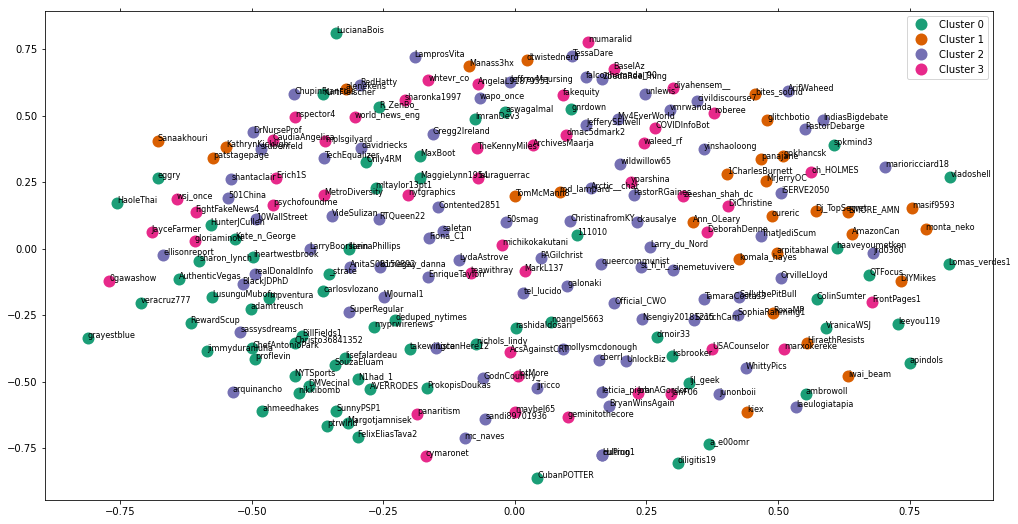

In [ ]:
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles.values)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05)
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',         # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',        # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1) 
for i in range(len(df)):
    ax.text(df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[i]['title'], size=8)  

plt.show()

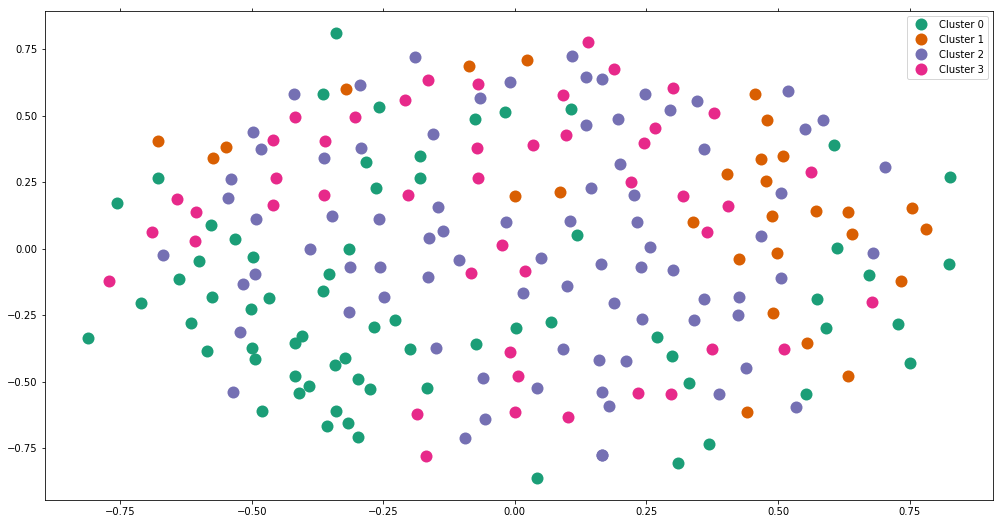

In [ ]:
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles.values)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05)
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',         # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',        # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)    
plt.show()

In [ ]:
#adding cluster labels in the usersData 
usersData['cluster'] = clusters

In [ ]:
# Import required packages
import logging
import pyLDAvis.gensim
from numpy import array
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora.dictionary import Dictionary
from gensim.models import Phrases

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [ ]:
!pip install pyLDAvis

     |████████████████████████████████| 1.7MB 558kB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.2.2-py2.py3-none-any.whl size=135593 sha256=d0a7181727776292eb33558f329c75f40d0bc9c55ed0acc8a574b0d0433d7c18
  Stored in directory: /root/.cache/pip/wheels/74/df/b6/97234c8446a43be05c9a8687ee0db1f1b5ade5f27729187eae
Successfully built pyLDAvis


In [ ]:
docs = array(usersData['ptweets'].apply(lambda x: x.split()))

# creating bigrams which appear atleast 10 times

bigram = Phrases(docs, min_count=10)
#trigram = Phrases(bigram[docs])

In [ ]:
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [ ]:
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=10, no_above=0.2)

corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))
print(corpus[:1])

Number of unique tokens: 323
Number of documents: 222
[[(0, 1), (1, 1), (2, 1)]]


In [ ]:
usersData['corpus'] = corpus
usersData['docs'] = docs
#create unique list of names
UniqueNames = usersData['cluster'].unique()

In [ ]:
#create a data frame dictionary to store data frames
DataFrameDict = {elem : pd.DataFrame for elem in UniqueNames}
docscluster={elem : pd.DataFrame for elem in UniqueNames}
corpuscluster={elem : pd.DataFrame for elem in UniqueNames}
dictionarycluster={elem : pd.DataFrame for elem in UniqueNames}

In [ ]:
for key in DataFrameDict.keys():
    DataFrameDict[key] = usersData[:][usersData.cluster == key]
    docscluster[key]=usersData['docs'][usersData.cluster == key]
    corpuscluster[key]=usersData['corpus'][usersData.cluster == key]
    dictionarycluster[key]=Dictionary(docscluster[key])

In [ ]:
lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, passes=50)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

In [ ]:
coherence_model_ldamallet = CoherenceModel(model=lda, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.3563788156309923


In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:ocs
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# Function to loop computing coherence measures for tuning LDAMallet model
#Used c_v parameter as method for computing coherence values
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)

        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list={elem : pd.DataFrame for elem in UniqueNames }
coherence_values={ elem : pd.DataFrame for elem in UniqueNames}
for i in np.arange(num_clusters):
    model_list[i], coherence_values[i] = compute_coherence_values(dictionary=dictionarycluster[i], corpus=corpuscluster[i], texts=docscluster[i], start=2, limit=6, step=1)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [ ]:
# Print the coherence scores
import math
best_value=np.array([])
optimal_model={elem : pd.DataFrame for elem in UniqueNames }
for i in np.arange(num_clusters):
    coherence_values[i]=[value for value in coherence_values[i] if not math.isnan(value)]
    best_value=np.append(best_value, np.amax(coherence_values[i])) 
    t=int(np.argmax(coherence_values[i]))
    optimal_model[i]=model_list[i][t]
    print("Cluster=",i,"has optimal number of topics as", t+2)#######################################################

Cluster= 0 has optimal number of topics as 5
Cluster= 1 has optimal number of topics as 3
Cluster= 2 has optimal number of topics as 3
Cluster= 3 has optimal number of topics as 2


In [ ]:
coherence_values

{0: [0.47575211349746194,
  0.44398315528939175,
  0.48183251703119906,
  0.5043534483686933],
 1: [0.419082752032889,
  0.4405880406736083,
  0.43797707446871803,
  0.4164811218002441],
 2: [0.3285963293058086,
  0.3870331369503182,
  0.36243541385931133,
  0.38238019776958276],
 3: [0.5278969905992164,
  0.49445536355852865,
  0.4788414677087961,
  0.517588028954646]}

In [ ]:
optimal_model[i].print_topics(num_words=4)


[(0, '0.015*"last" + 0.009*"theme" + 0.009*"garden" + 0.007*"buzz"'),
 (1, '0.013*"buzz" + 0.013*"last" + 0.012*"garden" + 0.011*"must"')]

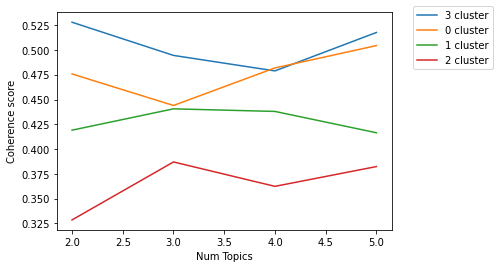

In [ ]:
import matplotlib.pyplot as plt
limit=6; start=2; step=1;
x={elem:list(range(start, limit, step)) for elem in (UniqueNames)}
for key in x.keys():
    plt.plot(x[key],coherence_values[key], label= str(key)+ ' cluster') 
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    
plt.legend(loc='best',bbox_to_anchor=(1.05, 1.05))
#plt.show()
plt.savefig('Coherence Sscor.png',bbox_inches='tight')

In [ ]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=docs):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [ ]:
from textblob.sentiments import NaiveBayesAnalyzer
import nltk
from textblob import TextBlob

In [ ]:
from textblob.sentiments import NaiveBayesAnalyzer
import nltk
from textblob import TextBlob

In [ ]:
polaritycluster={elem : pd.DataFrame for elem in UniqueNames}
subjectivitycluster={elem : pd.DataFrame for elem in UniqueNames}
for i in DataFrameDict.keys():
    polaritycluster[i]=TextBlob(' '.join(DataFrameDict[i]['tweets'].astype('str'))).sentiment.polarity
    subjectivitycluster[i]=TextBlob(' '.join(DataFrameDict[i]['tweets'].astype('str'))).sentiment.subjectivity

In [ ]:
polaritycluster


{0: 0.11144551849386229,
 1: 0.17235523063648062,
 2: 0.07888127940865697,
 3: 0.08613195139166775}

In [ ]:
subjectivitycluster

{0: 0.46413350319072405,
 1: 0.5102523790023796,
 2: 0.42538427416027047,
 3: 0.4692501919959907}

In [ ]:
# Using newspaper3k package
import newspaper
from newspaper import Article

# for similarity measure
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
cnn_paper = newspaper.build('https://www.wsj.com/') #CNN paper
WP_paper = newspaper.build('https://www.washingtonpost.com',language='en') # WP paper 
NYT_paper = newspaper.build('https://www.nytimes.com',language='en') # NYT pape

/usr/local/lib/python3.7/dist-packages/newspaper/parsers.py:71: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  log.warn('fromstring() returned an invalid string: %s...', html[:20])
/usr/local/lib/python3.7/dist-packages/requests/utils.py:444: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion on issue #2266. (This warning should only appear once.)
  DeprecationWarning)


In [ ]:
import pandas as pd
df_text = pd.DataFrame(columns=['Link','text'])
for article in cnn_paper.articles:
    link = article.url
    try:
        
        article.download()
        article.parse()
        article.nlp()
        article.text
        temp={'Link':link,
              'text':article.text}
        df_text= df_text.append(temp,ignore_index=True)
        
    except:
        pass
for article in WP_paper.articles:
    link = article.url
    try:
        
        article.download()
        article.parse()
        article.nlp()
        article.text
        temp={'Link':link,
              'text':article.text}
        df_text= df_text.append(temp,ignore_index=True)
        
    except:
        pass
for article in NYT_paper.articles:
    link = article.url
    try:
        
        article.download()
        article.parse()
        article.nlp()
        article.text
        temp={'Link':link,
              'text':article.text}
        df_text= df_text.append(temp,ignore_index=True)
        
    except:
        pass

/usr/local/lib/python3.7/dist-packages/requests/utils.py:444: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion on issue #2266. (This warning should only appear once.)
  DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/requests/utils.py:444: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion on issue #2266. (This warning should only appear once.)
  DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/requests/utils.py:444: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion on issue #2266. (This warning should only appear once.)
  DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/requests/utils.py:444: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion on

In [ ]:
df_text

,Link,text
0,https://www.washingtonpost.com/politics/capito...,Three officials who have resigned — Capitol Po...
1,https://www.washingtonpost.com/politics/capito...,But the alert was not flagged for top official...
2,https://www.washingtonpost.com/politics/2021/0...,“He describes four different types of people: ...
3,https://www.washingtonpost.com/nation/2021/02/...,"Optics were introduced by Paul Irving, the for..."
4,https://www.washingtonpost.com/technology/2021...,"Commonly known as chips, semiconductors are cr..."
...,...,...
196,https://cn.nytimes.com/business/20210208/hna-w...,
197,https://cn.nytimes.com/interactive/20210208/to...,
198,https://cn.nytimes.com/interactive/20210208/to...,
199,https://cn.nytimes.com/interactive/20210208/to...,


In [ ]:
def processArticles(articles):
    
    #cleaning of articles
    cleanedarticles = []
    for article in articles: 
        article = re.sub("[^a-zA-Z]"," ", str(article))
        article = article.lower() #converting to lowercase letters
        article = ' '.join([word for word in article.split() if word not in (stop)]) #removing stop words
        article = ' '.join([word for word in article.split() if len(word)>2])   
    
        #tokenization
        article = nltk.word_tokenize(article)
    
        #stemming
        article = [ps.stem(word) for word in article]
    
        #lammitization
        article = [wn.lemmatize(word) for word in article]
    
        article = [word for word in article if len(word)>2]
        article = ' '.join(w for w in article if w in words)
    
        cleanedarticles.append(article)
    return cleanedarticles

In [ ]:
df_text['text'] = processArticles(df_text['text'])
df_text.head()

,Link,text
0,https://www.washingtonpost.com/politics/capito...,three resign chief steven sergeant arm sergean...
1,https://www.washingtonpost.com/politics/capito...,alert flag top either accord deepen question b...
2,https://www.washingtonpost.com/politics/2021/0...,four differ type agent fake trump protest unif...
3,https://www.washingtonpost.com/nation/2021/02/...,optic former sergeant arm much day way use cha...
4,https://www.washingtonpost.com/technology/2021...,known chip semiconductor critic function wide ...


In [ ]:
docs = array(df_text['text'].apply(lambda x : x.split())) ####################################################################
bigram = Phrases(docs, min_count=10)

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [ ]:
# Remove rare and common tokens 
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=10, no_above=0.2)

#Create dictionary and corpus required for Topic Modeling
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 735
Number of documents: 201


In [ ]:
pol=[TextBlob(' '.join(df_text.iloc[i,1])).sentiment.polarity for i in range(df_text.shape[0])]
sub=[TextBlob(' '.join(df_text.iloc[i,1])).sentiment.subjectivity for i in range(df_text.shape[0])]
df_text['pol']=pol
df_text['sub']=sub

In [ ]:
# Function to analyze the developed topic models on unseen corpus of texts (in our case News articles)
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=docs):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [ ]:
# The percent contribution of each topic model considered as metric to assign topic score
df_topic_sents_keywords={elem : pd.DataFrame for elem in UniqueNames}
topicss=pd.DataFrame()
for i in range(len(UniqueNames)):
    mod=optimal_model[i]#gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model[i])
    temp={'cluster':i,
         'model':mod}
    topicss=topicss.append(temp, ignore_index=True)
    df_topic_sents_keywords[i] = format_topics_sentences(ldamodel=mod, corpus=corpus, texts=docs)
    
    # Centre the percent contribution by subtracting the mean. This standardises topic score
    df_topic_sents_keywords[i]['Diff']= df_topic_sents_keywords[i]['Perc_Contribution']-np.mean(df_topic_sents_keywords[i]['Perc_Contribution'])

In [ ]:
sentiment={elem: pd.DataFrame for elem in UniqueNames}
subjectivit={elem: pd.DataFrame for elem in UniqueNames}
w1=0.8 # Topic modelling weight
w2=0.2 # Sentiment score weight
for i in range(len(UniqueNames)):
    sentiment[i]=cosine_similarity(np.array(df_text.iloc[:, 2]).reshape(-1, 1),np.array([polaritycluster[i]]).reshape(-1, 1))
    subjectivit[i]=cosine_similarity(np.array(df_text.iloc[:, 2]).reshape(-1, 1),np.array([subjectivitycluster[i]]).reshape(-1, 1))
    df_topic_sents_keywords[i]['Polarity']=sentiment[i]
    df_topic_sents_keywords[i]['Subjectivity']=subjectivit[i]
    df_topic_sents_keywords[i]['Metric']=w1*df_topic_sents_keywords[i]['Diff']+w2/2*(df_topic_sents_keywords[i]['Polarity']+df_topic_sents_keywords[i]['Subjectivity'])

In [ ]:
# Recommendation dataframe
recommend=pd.DataFrame()
metric_value=pd.DataFrame()
rec=np.array([])
for i in range(len(docs)):
    for j in range(len(UniqueNames)):
        rec=np.append(rec, df_topic_sents_keywords[j].iloc[i,7])
        
    recommend=recommend.append(pd.Series(np.argmax(rec)),ignore_index=True)
    metric_value=metric_value.append(pd.Series(np.amax(rec)),ignore_index=True)
    rec=np.array([])

In [ ]:
recommend['metric']=metric_value
recommend['url']=df_text['Link']
recommend['article_text']=df_text['text']

#np.array([recommend,metric_value])
recommend #0 is cluster group

,0,metric,url,article_text
0,2.0,0.167655,https://www.washingtonpost.com/politics/capito...,three resign chief steven sergeant arm sergean...
1,2.0,0.267415,https://www.washingtonpost.com/politics/capito...,alert flag top either accord deepen question b...
2,3.0,0.168679,https://www.washingtonpost.com/politics/2021/0...,four differ type agent fake trump protest unif...
3,2.0,0.314135,https://www.washingtonpost.com/nation/2021/02/...,optic former sergeant arm much day way use cha...
4,3.0,0.138919,https://www.washingtonpost.com/technology/2021...,known chip semiconductor critic function wide ...
...,...,...,...,...
196,1.0,-0.146579,https://cn.nytimes.com/business/20210208/hna-w...,
197,1.0,-0.146579,https://cn.nytimes.com/interactive/20210208/to...,
198,1.0,-0.146579,https://cn.nytimes.com/interactive/20210208/to...,
199,1.0,-0.146579,https://cn.nytimes.com/interactive/20210208/to...,


In [ ]:
recommend.sort_values(by=['metric', 0], ascending ='False')

,0,metric,url,article_text
161,1.0,-0.146579,https://cn.nytimes.com/china/20210224/china-ho...,
162,1.0,-0.146579,https://cn.nytimes.com/morning-brief/20210224/...,
163,1.0,-0.146579,https://cn.nytimes.com/asia-pacific/20210223/m...,
165,1.0,-0.146579,https://cn.nytimes.com/world/20210222/russia-i...,
166,1.0,-0.146579,https://cn.nytimes.com/china/20210222/hong-kon...,
...,...,...,...,...
7,0.0,0.369786,https://www.washingtonpost.com/photography/int...,tiger wood serious roll end side suburban ange...
200,0.0,0.397626,https://cn.nytimes.com/china/20210205/china-co...,unit nation trade develop center intern coral ...
98,0.0,0.397946,https://www.thelily.com/shes-the-only-black-ki...,month later essay mute fifth grade publish ski...
37,0.0,0.416266,https://www.washingtonpost.com/video/politics/...,four year trump republican care tweet mani rep...


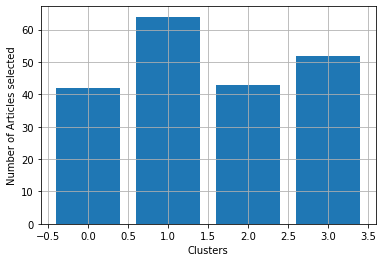

In [ ]:
import seaborn as sns
plt.bar(recommend[0].value_counts().index,recommend[0].value_counts())
plt.grid()
plt.xlabel('Clusters')
plt.ylabel('Number of Articles selected')
plt.savefig('Percentage Recommend.png',bbox_inches='tight')

In [ ]:
df_topic_sents_keywords

{0:      Dominant_Topic  Perc_Contribution  ... Subjectivity    Metric
 0               4.0             0.4594  ...          0.0  0.030826
 1               4.0             0.4309  ...          0.0  0.008026
 2               1.0             0.4317  ...          0.0  0.008666
 3               1.0             0.4345  ...          0.0  0.010906
 4               2.0             0.4550  ...          0.0  0.027306
 ..              ...                ...  ...          ...       ...
 196             0.0             0.2000  ...          0.0 -0.176694
 197             0.0             0.2000  ...          0.0 -0.176694
 198             0.0             0.2000  ...          0.0 -0.176694
 199             0.0             0.2000  ...          0.0 -0.176694
 200             2.0             0.9179  ...          0.0  0.397626
 
 [201 rows x 8 columns],
 1:      Dominant_Topic  Perc_Contribution  ... Subjectivity    Metric
 0               2.0             0.4968  ...          0.0 -0.015779
 1             

In [ ]:
def get_jaccard_sim(str1, str2): 
    a = set(str1) 
    b = set(str2)
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [ ]:
def GetUserRec(recommend, tweets,cluster):
    articles=recommend[recommend[0]==cluster]    
    articles['corp']= processArticles(articles['article_text'])
    tweetcorp=processTweets(tweets)
#     for i in range(articles.shape[0]):
#         articles.iloc[i,articles.shape[1]]
#         if i==0:
#             jaccard_similar=get_jaccard_sim(tweetcorp,articles.iloc[i,articles.shape[1]])
#         else:
#             jaccard_similar=np.append(jaccard_similar,(get_jaccard_sim(tweetcorp,articles.iloc[i,articles.shape[1]])))
    #article['jaccard_similar']=cosine_similarity(tweetcorp,articles['corp'])
    articles['jaccard']=articles['corp'].apply(lambda x:get_jaccard_sim(tweets,x))
    ranked=articles.sort_values(by=['jaccard'], ascending=False)
    
    return ranked

In [ ]:
tweets="America's pastors and ministers have been great, resourceful leaders during this crisis. Now it's time to help Americans get back to their churches."

In [ ]:
GetUserRec(recommend,tweets,3)

,0,metric,url,article_text,corp,jaccard
154,3.0,0.184759,https://www.nytimes.com/2021/02/23/opinion/rep...,democrat start congress major leader bill nake...,democrat start congress major leader bill nake...,0.758621
153,3.0,0.236359,https://www.nytimes.com/2021/02/23/opinion/cov...,mental health restrict outweigh threat skeptic...,mental health restrict outweigh threat skeptic...,0.758621
113,3.0,0.228039,https://www.washingtonpost.com/pr/2020/07/30/w...,post organ commit build diver current post thr...,post organ commit build diver current post thr...,0.758621
20,3.0,0.124919,https://www.washingtonpost.com/lifestyle/welln...,start mask layer also come extra set stretch e...,start mask layer also come extra set stretch e...,0.758621
4,3.0,0.138919,https://www.washingtonpost.com/technology/2021...,known chip semiconductor critic function wide ...,known chip semiconductor critic function wide ...,0.758621
28,3.0,0.154119,https://www.washingtonpost.com/road-to-recover...,founder turn philanthropist bill gate rais eye...,founder turn philanthropist bill gate eyebrow ...,0.733333
150,3.0,0.062999,https://www.nytimes.com/2021/02/23/opinion/woo...,action tablet label creat enorm wrote budget p...,action tablet label creat enorm wrote budget p...,0.733333
122,3.0,0.110039,https://washingtonpost.com/terms-of-sale-for-d...,june term sale govern sale post digit product ...,june term sale govern sale post digit product ...,0.733333
115,3.0,0.109079,https://www.washingtonpost.com/terms-of-sale-f...,june term sale govern sale post digit product ...,june term sale govern sale post digit product ...,0.733333
100,3.0,0.179879,https://www.washingtonpost.com/goingoutguide/m...,skeleton closet ghost past present horror film...,skeleton closet ghost past present horror film...,0.733333


In [ ]:
get_jaccard_sim(tweets,recommend['article_text'][25])

0.7333333333333333